In [248]:
import sys
print("Python Version:", sys.version)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
pd.set_option('display.max_rows', 500)
%matplotlib inline

Python Version: 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]


In [249]:
# yymmdd format
dates = ['190803',
        '190810',
        '190817',
        '190824',
        '190831',
        '190907',
        '190914',
        '190921',
        '190928']

# iterate through dates and pull in csv and cat dataframes together
df_turns = []
for date in dates:
    df_turns.append(pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_'+date+'.txt'))
    
# Concat all dataframes
df_turns = pd.concat(df_turns)  

In [250]:
#Clean up the column Names
new_col_names = [name.strip() for name in df_turns.columns]
df_turns.columns = new_col_names


In [251]:
# Remove audited rows
df_turns=df_turns[df_turns.DESC!='RECOVR AUD']
# remove column?
del df_turns['DESC']

In [252]:
# Create a DateTime column that can be used for timeseries
df_turns.loc[:,'DATETIME'] = pd.to_datetime(df_turns['DATE'] + ' ' + df_turns['TIME'])

#Convert Date column to proper date type.
df_turns['DATE']  = pd.to_datetime(df_turns['DATE'],format='%m/%d/%Y')

#convert time to datetime type
df_turns['TIME']=pd.to_datetime(df_turns['TIME'], format='%H:%M:%S')

In [253]:
#backup
df_backup=df_turns.copy()

In [254]:
#Sort in order of datetime
df_turns = df_turns.sort_values(by=['DATETIME']).reset_index()

In [255]:
# Caluclate Entries Aggregated at station level by DateTime
df_turns['Entry_Diff']=df_turns.groupby(['STATION', 'C/A', 'UNIT', 'SCP'],as_index=False)['ENTRIES'].transform(pd.Series.diff)['ENTRIES']

# Caluclate Exits Aggregated at station level by DateTime
df_turns['Exit_Diff']=df_turns.groupby(['STATION', 'C/A', 'UNIT', 'SCP'],as_index=False)['EXITS'].transform(pd.Series.diff)['EXITS']



In [256]:
#Absolute Value to deal with counting backward issues 
df_turns['Entry_Diff'] = abs(df_turns['Entry_Diff'])
df_turns['Exit_Diff']=abs(df_turns['Exit_Diff'])

# Calculate both
df_turns['Total_Traffic']=df_turns['Entry_Diff']+df_turns['Exit_Diff']

### Rami's Filtering

In [257]:
def Add_Weekday(data_frame, column='Date'):
    dmap = {0:'Mon', 1: 'Tue', 2: 'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
    #Convert column to date
    data_frame[column] = pd.to_datetime(data_frame[column])
    #Add column which shows the Weekday in integer
    data_frame['Day_Number'] = data_frame[column].apply(lambda x: x.dayofweek)
    #Add column which shows the Weekday in words
    data_frame['Weekday'] = data_frame['Day_Number'].map(dmap)
    return data_frame
df_turns_backup2 = df_turns.copy()

In [258]:
df_turns = Add_Weekday(df_turns, 'DATE')

In [259]:
#Filter out the Null Values
df_turns.dropna(subset=["Entry_Diff","Exit_Diff",'Total_Traffic'], axis=0, inplace=True)
df_turns.head()

,index,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,EXITS,DATETIME,Entry_Diff,Exit_Diff,Total_Traffic,Day_Number,Weekday
2554,118307,PTH03,R552,00-01-08,JOURNAL SQUARE,1,PTH,2019-07-27,1900-01-01 00:24:57,65,30,2019-07-27 00:24:57,2.0,0.0,2.0,5,Sat
2592,118308,PTH03,R552,00-01-08,JOURNAL SQUARE,1,PTH,2019-07-27,1900-01-01 00:38:57,65,30,2019-07-27 00:38:57,0.0,0.0,0.0,5,Sat
2636,118309,PTH03,R552,00-01-08,JOURNAL SQUARE,1,PTH,2019-07-27,1900-01-01 00:52:57,65,30,2019-07-27 00:52:57,0.0,0.0,0.0,5,Sat
2640,118310,PTH03,R552,00-01-08,JOURNAL SQUARE,1,PTH,2019-07-27,1900-01-01 00:56:25,4043,3513,2019-07-27 00:56:25,3978.0,3483.0,7461.0,5,Sat
4489,118311,PTH03,R552,00-01-08,JOURNAL SQUARE,1,PTH,2019-07-27,1900-01-01 01:06:57,65,30,2019-07-27 01:06:57,3978.0,3483.0,7461.0,5,Sat


In [260]:
dfc_grouped = df_turns.groupby(['DATE', 'STATION', 'Weekday'])['Entry_Diff', 'Exit_Diff', 'Total_Traffic'].sum().reset_index()

C:\Users\atag3\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [355]:
#The upper_quant_df outputs a dataframe of the upper 95% values for each station
upper_quant_df = dfc_grouped.groupby(['STATION'])['Total_Traffic'].quantile([.95]).reset_index()
#Then I merge it with the grouped data 
df_turns_no_outlier = dfc_grouped.merge(upper_quant_df, on='STATION')
df_turns_no_outlier.head()

,DATE,STATION,Weekday,Entry_Diff,Exit_Diff,Total_Traffic_x,level_1,Total_Traffic_y
0,2019-07-27,1 AV,Sat,4308.0,5146.0,9454.0,0.95,40228.0
1,2019-07-28,1 AV,Sun,4106.0,5309.0,9415.0,0.95,40228.0
2,2019-07-29,1 AV,Mon,14483.0,16525.0,31008.0,0.95,40228.0
3,2019-07-30,1 AV,Tue,16375.0,18206.0,34581.0,0.95,40228.0
4,2019-07-31,1 AV,Wed,16812.0,19777.0,36589.0,0.95,40228.0


In [356]:
#delete the rows where The difference between Total_Traffic_y and Total_Traffic_x < 0
df_turns_no_outlier['Diff'] = df_turns_no_outlier['Total_Traffic_y'] - df_turns_no_outlier['Total_Traffic_x']
df_turns_no_outlier = df_turns_no_outlier[df_turns_no_outlier['Diff']>= 0]

In [357]:
df_turns_no_outlier.sample(50)

,DATE,STATION,Weekday,Entry_Diff,Exit_Diff,Total_Traffic_x,level_1,Total_Traffic_y,Diff
17996,2019-09-16,MT EDEN AV,Mon,5302.0,3136.0,8438.0,0.95,9077.8,639.8
22283,2019-09-23,TWENTY THIRD ST,Mon,10527.0,12410.0,22937.0,0.95,36381.3,13444.3
5992,2019-08-06,7 AV,Tue,38542.0,36008.0,74550.0,0.95,83898.7,9348.7
18462,2019-08-09,NEVINS ST,Fri,9754.0,10030.0,19784.0,0.95,22373.7,2589.7
22619,2019-08-12,VERNON-JACKSON,Mon,14708.0,9830.0,24538.0,0.95,29941.4,5403.4
22732,2019-07-30,W 8 ST-AQUARIUM,Tue,3590.0,3056.0,6646.0,0.95,7740.2,1094.2
14474,2019-09-19,GRAND ST,Thu,33063.0,26234.0,59297.0,0.95,60969.4,1672.4
9482,2019-09-03,BEDFORD-NOSTRAN,Tue,8331.0,4597.0,12928.0,0.95,15425.0,2497.0
9162,2019-08-29,BEACH 67 ST,Thu,2611.0,1977.0,4588.0,0.95,4982.6,394.6
19381,2019-09-15,ORCHARD BEACH,Sun,0.0,0.0,0.0,0.95,185.2,185.2


In [271]:
df_per_station = df_turns_no_outlier.groupby(['STATION']).mean()
df_per_station.sort_values('Total_Traffic_x', ascending=False).head(100)

,Entry_Diff,Exit_Diff,Total_Traffic_x,level_1,Total_Traffic_y,Diff
STATION,,,,,,
GRD CNTRL-42 ST,158716.627119,146812.033898,305528.661017,0.95,2310450.70,2.004922e+06
34 ST-PENN STA,136887.271186,126923.932203,263811.203390,0.95,338810.80,7.499960e+04
34 ST-HERALD SQ,105549.067797,101689.559322,207238.627119,0.95,252136.40,4.489777e+04
TIMES SQ-42 ST,86884.677966,82042.779661,168927.457627,0.95,209555.50,4.062804e+04
23 ST,94877.779661,71002.203390,165879.983051,0.95,234861.20,6.898122e+04
14 ST-UNION SQ,84560.440678,80791.050847,165351.491525,0.95,211816.60,4.646511e+04
42 ST-PORT AUTH,89811.610169,74852.288136,164663.898305,0.95,198791.90,3.412800e+04
FULTON ST,83855.474576,75217.169492,159072.644068,0.95,507437.00,3.483644e+05
86 ST,69421.847458,66910.830508,136332.677966,0.95,182628.40,4.629572e+04


# End of group data cleaning 

## Begin Working on Demographics info

##### Rest of the team should use the above code so we are all working with the same data.

In [273]:
# bring in Census data
cen_dat = pd.read_csv('geocoded_cen_dat.csv')
cen_vars=['STATION',
          'LAT',
          'LON',
          'p_f_pop',
          'p_emp_info',
          'p_emp_prof',
          'p_75_100k',
          'p_over_100k']

df_per_station = pd.merge(df_per_station, cen_dat[cen_vars],  how='left', left_on=['STATION'], right_on = ['STATION'])
df_per_station =df_per_station.drop_duplicates(['STATION'])
df_per_station.sort_values('Total_Traffic_x', ascending=False).head(100)

,STATION,Entry_Diff,Exit_Diff,Total_Traffic_x,level_1,Total_Traffic_y,Diff,LAT_x,LON_x,p_f_pop_x,...,p_emp_prof_x,p_75_100k_x,p_over_100k_x,LAT_y,LON_y,p_f_pop_y,p_emp_info_y,p_emp_prof_y,p_75_100k_y,p_over_100k_y
290,GRD CNTRL-42 ST,158716.627119,146812.033898,305528.661017,0.95,2310450.70,2.004922e+06,40.755861,-73.987061,0.245455,...,0.355263,0.453,0.297,40.755861,-73.987061,0.245455,0.092105,0.355263,0.453,0.297
81,34 ST-PENN STA,136887.271186,126923.932203,263811.203390,0.95,338810.80,7.499960e+04,40.751056,-73.990310,0.379121,...,0.228571,0.128,0.684,40.751056,-73.990310,0.379121,0.235714,0.228571,0.128,0.684
78,34 ST-HERALD SQ,105549.067797,101689.559322,207238.627119,0.95,252136.40,4.489777e+04,40.750087,-73.988127,0.379121,...,0.228571,0.128,0.684,40.750087,-73.988127,0.379121,0.235714,0.228571,0.128,0.684
420,TIMES SQ-42 ST,86884.677966,82042.779661,168927.457627,0.95,209555.50,4.062804e+04,40.755861,-73.987061,0.245455,...,0.355263,0.453,0.297,40.755861,-73.987061,0.245455,0.092105,0.355263,0.453,0.297
62,23 ST,94877.779661,71002.203390,165879.983051,0.95,234861.20,6.898122e+04,40.741201,-73.989034,0.525245,...,0.238662,0.130,0.720,40.741201,-73.989034,0.525245,0.092991,0.238662,0.130,0.720
22,14 ST-UNION SQ,84560.440678,80791.050847,165351.491525,0.95,211816.60,4.646511e+04,40.734537,-73.990324,0.512696,...,0.175355,0.083,0.684,40.734537,-73.990324,0.512696,0.095516,0.175355,0.083,0.684
90,42 ST-PORT AUTH,89811.610169,74852.288136,164663.898305,0.95,198791.90,3.412800e+04,40.757835,-73.991463,0.403017,...,0.151951,0.140,0.485,40.757835,-73.991463,0.403017,0.052671,0.151951,0.140,0.485
280,FULTON ST,83855.474576,75217.169492,159072.644068,0.95,507437.00,3.483644e+05,40.710648,-74.009296,0.560466,...,0.311535,0.160,0.592,40.710648,-74.009296,0.560466,0.042380,0.311535,0.160,0.592
140,86 ST,69421.847458,66910.830508,136332.677966,0.95,182628.40,4.629572e+04,40.777741,-73.951567,0.486410,...,0.172976,0.146,0.520,40.777741,-73.951567,0.486410,0.060634,0.172976,0.146,0.520
14,125 ST,66914.237288,57072.661017,123986.898305,0.95,155104.80,3.111790e+04,40.804386,-73.937429,0.462644,...,0.074046,0.058,0.072,40.804386,-73.937429,0.462644,0.068702,0.074046,0.058,0.072


In [247]:
cen_dat.head()

,STATION,DIVISION,all,LAT,LON,geo_type,State_FIPS,County_FIPS,Tract_FIPS,f_pop,all_pop,p_emp_info,p_f_pop,p_emp_prof,p_75_100k,p_over_100k
0,1 AV,BMT,19409616052,40.731327,-73.982435,establishment,36,61,4400,9661.0,16684.0,0.077069,0.579058,0.226378,0.166,0.396
1,103 ST,IND,2344428272,40.796286,-73.961648,establishment,36,61,18900,6869.0,11800.0,0.057668,0.582119,0.170079,0.050,0.235
2,103 ST,IRT,4382729249,40.796286,-73.961648,establishment,36,61,18900,6869.0,11800.0,0.057668,0.582119,0.170079,0.050,0.235
3,103 ST-CORONA,IRT,2641087500,40.749827,-73.862746,establishment,36,81,40501,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,104 ST,BMT,18924221,40.695146,-73.844305,establishment,36,81,2800,1602.0,3382.0,0.033613,0.473684,0.039016,0.077,0.080


In [342]:
df_per_station['Traffic_Rank'] = df_per_station['Total_Traffic_x'].rank(ascending=True,pct=True)*100
df_per_station['p_f_pop_Rank'] = df_per_station['p_f_pop_y'].rank(ascending=True,pct=True)*100
df_per_station['p_emp_info_Rank'] = df_per_station['p_emp_info_y'].rank(ascending=True,pct=True)*100
df_per_station['p_emp_prof_Rank'] = df_per_station['p_emp_prof_y'].rank(ascending=True,pct=True)*100
df_per_station['p_75_100k_Rank'] = df_per_station['p_75_100k_y'].rank(ascending=True,pct=True)*100
df_per_station['p_over_100k_Rank'] = df_per_station['p_over_100k_y'].rank(ascending=True,pct=True)*100

df_per_station.sort_values('Total_Traffic_x', ascending=False).head(100)

df_per_station['Recommending_Score'] = (df_per_station['Traffic_Rank'] * .50) +\
                                       (df_per_station['p_f_pop_Rank'] * .2)+ \
                                       (df_per_station['p_emp_info_Rank'] * .1)+ \
                                       (df_per_station['p_emp_prof_Rank'] * .1)+ \
                                       (df_per_station['p_75_100k_Rank'] * .05)+ \
                                       (df_per_station['p_over_100k_Rank'] * .05)

df_per_station.sort_values('Recommending_Score', ascending=False).head(100)

,STATION,Entry_Diff,Exit_Diff,Total_Traffic_x,level_1,Total_Traffic_y,Diff,LAT_x,LON_x,p_f_pop_x,...,p_emp_prof_y,p_75_100k_y,p_over_100k_y,Traffic_Rank,p_f_pop_Rank,p_emp_info_Rank,p_emp_prof_Rank,p_75_100k_Rank,p_over_100k_Rank,Recommending_Score
435,WALL ST,33564.949153,29166.644068,62731.593220,0.95,90272.20,2.754061e+04,40.706397,-74.009444,0.571802,...,0.316684,0.152,0.550,92.857143,86.950147,80.973451,98.377581,78.425656,83.236152,89.836794
70,28 ST,37509.016949,34094.237288,71603.254237,0.95,99685.90,2.808265e+04,40.747069,-73.993509,0.597854,...,0.219014,0.149,0.612,93.650794,94.134897,70.796460,84.070796,76.239067,88.629738,89.382542
280,FULTON ST,83855.474576,75217.169492,159072.644068,0.95,507437.00,3.483644e+05,40.710648,-74.009296,0.560466,...,0.311535,0.160,0.592,98.148148,82.111437,56.342183,97.345133,83.090379,86.297376,89.334481
103,51 ST,17204.596491,19178.929825,36383.526316,0.95,52267.55,1.588402e+04,40.757135,-73.971912,0.601244,...,0.308096,0.247,0.453,85.185185,95.014663,76.106195,95.575221,97.376093,78.717201,87.568331
62,23 ST,94877.779661,71002.203390,165879.983051,0.95,234861.20,6.898122e+04,40.741201,-73.989034,0.525245,...,0.238662,0.130,0.720,98.941799,59.970674,88.643068,89.233038,66.618076,96.938776,87.430488
157,ATL AV-BARCLAY,35700.067797,33934.711864,69634.779661,0.95,90896.40,2.126162e+04,40.683760,-73.978757,0.547800,...,0.214960,0.161,0.413,93.386243,71.847507,82.300885,83.480826,83.965015,77.842566,85.731173
130,77 ST,25063.322034,22149.796610,47213.118644,0.95,65100.40,1.788728e+04,40.773635,-73.959829,0.557976,...,0.245014,0.114,0.613,89.947090,79.178886,82.595870,91.150442,57.580175,88.921283,85.509026
197,BOWLING GREEN,24572.864407,23543.186441,48116.050847,0.95,62810.30,1.469425e+04,40.704811,-74.014460,0.560466,...,0.311535,0.160,0.592,90.211640,82.111437,56.342183,97.345133,83.090379,86.297376,85.366227
272,FOREST HILLS 71,21933.508475,11393.271186,33326.779661,0.95,43500.50,1.017372e+04,40.721691,-73.844521,0.573224,...,0.219474,0.251,0.412,83.068783,87.390029,80.235988,84.365782,97.667638,77.259475,84.218930
331,LEXINGTON AV/63,17276.338983,18571.101695,35847.440678,0.95,50271.40,1.442396e+04,40.764629,-73.966113,0.596531,...,0.236400,0.098,0.677,84.920635,93.695015,55.309735,88.053097,48.688047,94.023324,82.671172


In [338]:
import folium
from folium.plugins import MarkerCluster

In [339]:
from colour import Color
red = Color("red")
colors = list(red.range_to(Color("green"),100))

In [343]:
#reset index of df per station
df_per_station_map = df_per_station.sort_values('Recommending_Score', ascending=False).head(100).reset_index(drop=True)

#stations
stations = df_per_station_map[['LAT_y','LON_y']]
stations_list=stations.values.tolist()
#Define coordinates of map center
nyc_coords = [40.7528, -73.9560]

#Create the map
my_map = folium.Map(location = nyc_coords, zoom_start = 12)

#Display the map
my_map

for point in range(0, len(stations_list)):
    if point <=10:
         folium.Circle(stations_list[point], popup=df_per_station_map.STATION[point],fill=True,radius=500,color='#00933C').add_to(my_map)
    else:
        folium.Circle(stations_list[point], popup=df_per_station_map.STATION[point],fill=True,radius=100,color='#FCCC0A').add_to(my_map)

folium.TileLayer('cartodbdark_matter').add_to(my_map)
#folium.TileLayer('cartodbpositron').add_to(my_map)
my_map

In [344]:
#reset index of df per station
df_per_station_map_traf = df_per_station.sort_values('Total_Traffic_x', ascending=False).head(100).reset_index(drop=True)

#stations
stations_traf = df_per_station_map_traf[['LAT_y','LON_y']]
stations_list_traf=stations_traf.values.tolist()


for point in range(0,10):
    folium.Circle(stations_list_traf[point], popup=df_per_station_map_traf.STATION[point],fill=True,radius=500,color='#FF6319').add_to(my_map)
       

In [345]:
my_map

In [358]:
df_turns_no_outlier.Weekday.unique()

array(['Sat', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri'], dtype=object)

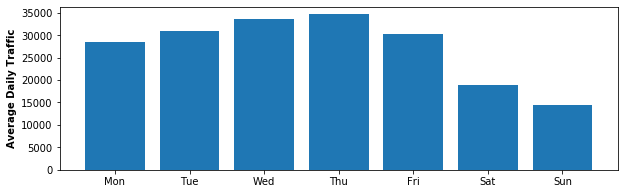

In [361]:
df_turns_no_outlier.sample(50)

# Set order fo days to start with weekday
df_turns_no_outlier['Weekday'] = pd.Categorical(df_turns_no_outlier['Weekday'], categories=
    ['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'],
    ordered=True)

#plot average 
plt.figure(figsize=(10,3))
plt.bar(x=df_turns_no_outlier.groupby(['DATE','Weekday'],as_index=False).mean().Weekday,height= df_turns_no_outlier.groupby(['DATE','Weekday'],as_index=False).mean().Total_Traffic_x)
plt.ylabel('Average Daily Traffic',fontsize = 10, weight = 'bold');